In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
import os
import numpy as np
import scipy.stats as stats

ROOT_PATH = Path('/mnt/2021_NIA_data/projects/nbb')
VIDEO_PATH = ROOT_PATH.joinpath("video")
HEADPOSE_PATH = VIDEO_PATH.joinpath("headpose_data")

# Determine the project path based on the current working directory or the script's path
try:
    PROJECT_PATH = Path(__file__).parents[1]
except NameError:
    PROJECT_PATH = Path(os.getcwd()).parents[0]

FIGURE_PATH = Path(PROJECT_PATH, "figures")


def skewness(series):
    return stats.skew(series)

def kurtosis(series):
    return stats.kurtosis(series)

data = pd.read_csv(Path(HEADPOSE_PATH, "headpose_values.csv"))
data['participant_id'] = data['participant_id'].str.replace('td', '').astype(int)

In [21]:
# Compute summary statistics for each head-pose feature per participant
summary_values = data.groupby('participant_id')[['yaw', 'pitch', 'roll']].agg([np.mean, np.std, skewness, kurtosis]).reset_index()

# Flatten multiindex columns
summary_values.columns = [col[0] if col[1] == '' else '_'.join(col) for col in summary_values.columns.values]

# Scale the summary statistics
scaler = StandardScaler()
summary_values_scaled = scaler.fit_transform(summary_values.drop(columns=['participant_id']))

In [22]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(summary_values_scaled)

/home/cko4/2023_asd_gaze/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [23]:
summary_values['cluster'] = kmeans.labels_

In [24]:
summary_values.head()

,participant_id,yaw_mean,yaw_std,yaw_skewness,yaw_kurtosis,pitch_mean,pitch_std,pitch_skewness,pitch_kurtosis,roll_mean,roll_std,roll_skewness,roll_kurtosis,cluster
0,1,-73.214221,19.173251,-0.552882,-0.067540,-32.101528,15.449905,0.130816,-0.521413,-129.732019,26.363008,0.080685,-0.750544,0
1,2,-36.613067,44.421713,0.156903,0.436688,5.674953,39.672646,0.226559,-0.529090,61.797244,130.148759,-0.655501,-1.121644,0
2,5,-17.973520,61.847928,0.088364,-1.860269,-13.218631,12.036875,1.352900,1.905768,49.830527,54.513070,0.040529,-1.522841,1
3,6,-21.829601,66.584096,0.407703,-1.624944,-17.836736,9.478149,1.069306,2.139619,51.943744,57.738960,-0.246673,-1.541869,1


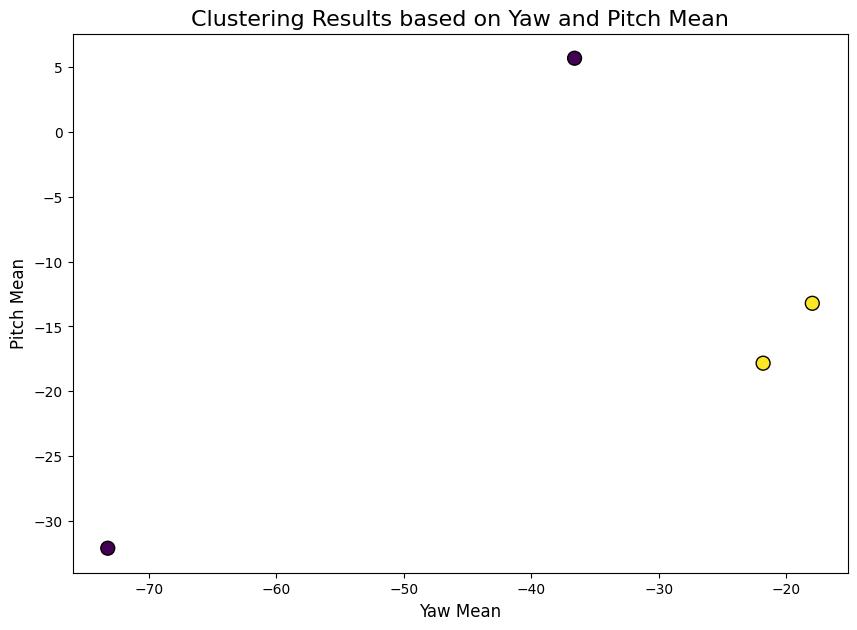

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(summary_values['yaw_mean'], summary_values['pitch_mean'], c=summary_values['cluster'], cmap='viridis', s=100, edgecolors='k')
plt.xlabel('Yaw Mean', fontsize=12)
plt.ylabel('Pitch Mean', fontsize=12)
plt.title('Clustering Results based on Yaw and Pitch Mean', fontsize=16)
plt.show()

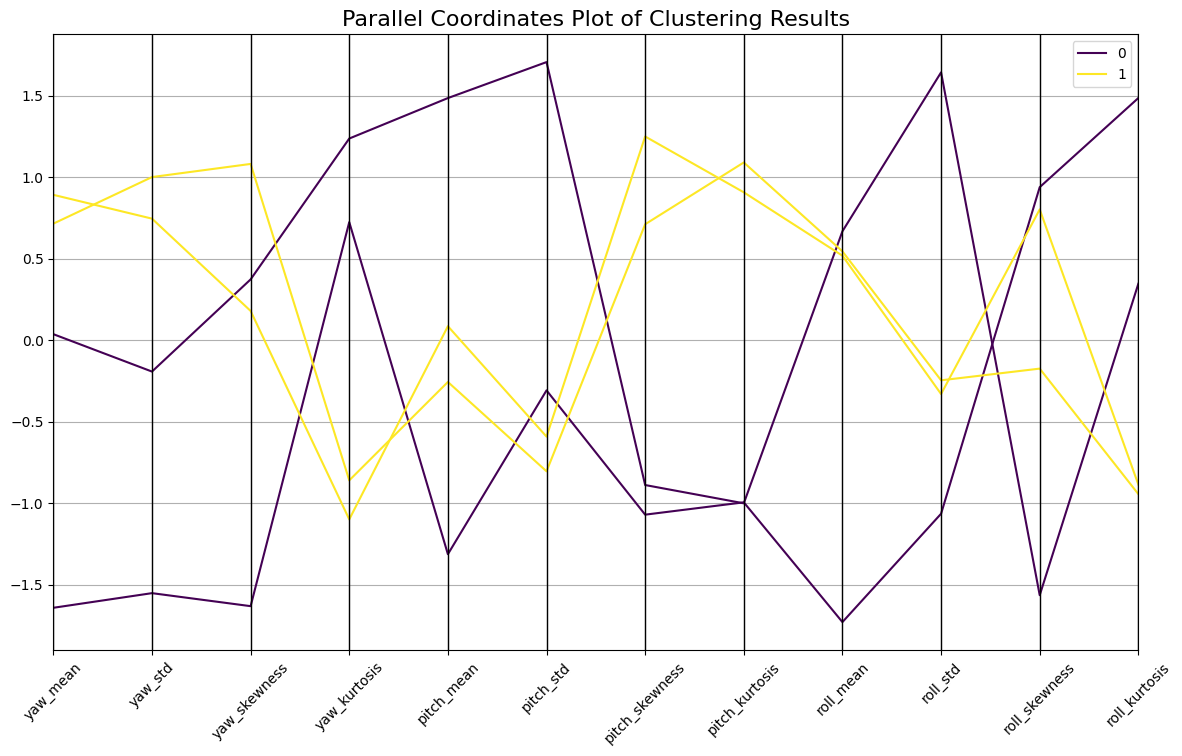

In [27]:
from pandas.plotting import parallel_coordinates

# Add cluster labels to the summary_values_scaled DataFrame
summary_values_scaled_df = pd.DataFrame(summary_values_scaled, columns=summary_values.columns.drop(['participant_id', 'cluster']))
summary_values_scaled_df['cluster'] = summary_values['cluster']

plt.figure(figsize=(14, 8))
parallel_coordinates(summary_values_scaled_df, 'cluster', colormap='viridis')
plt.title('Parallel Coordinates Plot of Clustering Results', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [28]:
for cluster, participants in summary_values.groupby('cluster')['participant_id']:
    print(f"Cluster {cluster}: {participants.values}")

Cluster 0: [1 2]
Cluster 1: [5 6]
